# 추천 모델 구현

### 주제 : 주어진 DeepFM 라이브러리를 이용하여 영화 추천 모델 만들기
* userId가 title인 영화를 볼 확률을 구하는 모델을 만드세요.
* 해당 과제의 경우 모델 훈련 뿐만 아닌, train_test_split으로 분기한 test 데이터의 pred_y 값을 [userId, title, pred] 세개의 열을 보유한 csv 파일로 저장하는 것까지 해주세요.

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from deepctr.models import DeepFM

import warnings
warnings.filterwarnings(action="ignore")

In [18]:
from deepctr.models import DeepFM
from sklearn.metrics import r2_score

class DeepFMModel:
    def __init__(self,feature_columns,task='regression'):
        self.feature_columns = feature_columns
        self.task = task
        self.optimizer = optimizer
        self.loss = loss
        self.metrics_list = metrics_list
        self.epochs = epochs
        self.model = None


    def _build(self,feature_columns, task, optimizer='adam', loss='mae', metrics_list=['mae']):
        model = DeepFM(*feature_columns, task=task)
        model.compile(optimizer, loss, metrics=[metrics_list])

        return model
    
    def train(self,input,target,epochs):
        self.model = self._build(self.feature_columns, self.task)
        hist = self.model.fit(input,target,epochs)

        self._save(self.model, )

        print("============================================================")
        

        return hist

    def predict(self,input_df):
        return self.model.predict(input_df)

    def evaluate(train_input,train_target):
        predict = self.predict(train_input)
        print("R2 Score: ", round(r2_score(predict, train_target),4))

    def _save(self, path):
        self.model.save(path)
        

In [2]:
# 데이터 불러오기

movie = pd.read_csv('./data/movielens.csv')

In [3]:
movie.head()

,userId,title,genres,tag,rating,target
0,1,Toy Story (1995),Adventure,toys,3.92,0
1,2,Toy Story (1995),Adventure,toys,3.92,0
2,3,Toy Story (1995),Adventure,toys,3.92,1
3,4,Toy Story (1995),Adventure,toys,3.92,0
4,5,Toy Story (1995),Adventure,toys,3.92,0


In [4]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  100000 non-null  int64  
 1   title   100000 non-null  object 
 2   genres  100000 non-null  object 
 3   tag     100000 non-null  object 
 4   rating  100000 non-null  float64
 5   target  100000 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


In [5]:
# 결측값 확인 
# 결측값이 없음을 확인함 

null_cnt_df = pd.DataFrame(movie.isnull().sum()).rename(columns={0: 'null_count'})
null_cnt_df['null_ratio'] = round(null_cnt_df['null_count']/len(movie) *100, 2)
null_cnt_df.sort_values('null_count')

,null_count,null_ratio
userId,0,0.0
title,0,0.0
genres,0,0.0
tag,0,0.0
rating,0,0.0
target,0,0.0


In [6]:
pd.DataFrame(movie.nunique()).rename(columns={0: '유일값 수'})

,유일값 수
userId,1000
title,100
genres,10
tag,71
rating,68
target,2


##### 데이터 설명 

* userId: 사용자ID (총 1000명)
* title: 영화제목 (총 100개)
* genres: 영화 장르 (총 10개)
* tag: 영화 태그 (총 71개)
* rating: 영화 평점
* target: 영화를 봤는지 안봤는지 (0=안봄, 1=영화를 봄)

In [7]:
# 정확한 영화제목을 따로 분리함
# 영화 개봉연도에 따른 취향이 있기때문에 연도도 따로 분리함 

In [8]:
movie['title_name'] = movie['title'].apply(lambda x: x.split('(1')[0])
movie['title_year'] = movie['title'].apply(lambda x: x.split('(')[-1].replace(")", "")).astype(int)

### 시각화

<Axes: xlabel='rating', ylabel='Density'>

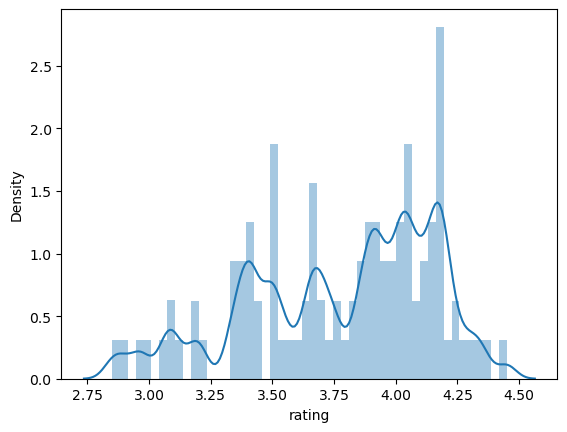

In [9]:
sns.distplot(movie['rating'])

<Axes: xlabel='title_year', ylabel='Density'>

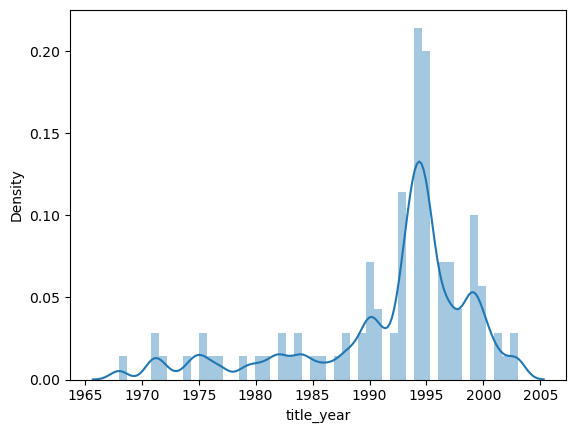

In [10]:
sns.distplot(movie['title_year'])

* 시각화를 통해 최소최대값의 편차와 빈도가 어느정도인지 확인함. 그래서 편차가 작은 영화 평점은 MinMaxScaling을 진행하고, 영화개봉연도는 StandardScaling을 진행할 것이다.
* 또한 이산형 변수들은 label Encoding을 할 것이다.
    - genres, tag, title_name

### Scaling
##### 연속형 변수 (MinMaxScaling)

In [11]:
mm = MinMaxScaler()
rating_data = movie['rating'].values.reshape(-1, 1)
movie['rating'] = mm.fit_transform(rating_data)
movie['rating']

0        0.66875
1        0.66875
2        0.66875
3        0.66875
4        0.66875
          ...   
99995    0.80625
99996    0.80625
99997    0.80625
99998    0.80625
99999    0.80625
Name: rating, Length: 100000, dtype: float64

In [12]:
ss = StandardScaler()
age_data = movie['title_year'].values.reshape(-1, 1)
movie['title_year'] = ss.fit_transform(age_data)
movie['title_year']

0        0.418881
1        0.418881
2        0.418881
3        0.418881
4        0.418881
           ...   
99995    1.462820
99996    1.462820
99997    1.462820
99998    1.462820
99999    1.462820
Name: title_year, Length: 100000, dtype: float64

##### 이산형 변수 (label Encoding)

In [13]:
encoder = LabelEncoder()

In [14]:
genres = movie['genres'].values.reshape(-1, 1)
encoder.fit(movie['genres'])
movie['genres'] = encoder.transform(genres)

In [15]:
tag = movie['tag'].values.reshape(-1, 1)
encoder.fit(movie['tag'])
movie['tag'] = encoder.transform(tag)

In [16]:
title_name = movie['title_name'].values.reshape(-1, 1)
encoder.fit(movie['title_name'])
movie['title_name'] = encoder.transform(title_name)

In [17]:
movie

,userId,title,genres,tag,rating,target,title_name,title_year
0,1,Toy Story (1995),1,65,0.66875,0,92,0.418881
1,2,Toy Story (1995),1,65,0.66875,0,92,0.418881
2,3,Toy Story (1995),1,65,0.66875,1,92,0.418881
3,4,Toy Story (1995),1,65,0.66875,0,92,0.418881
4,5,Toy Story (1995),1,65,0.66875,0,92,0.418881
...,...,...,...,...,...,...,...,...
99995,996,"Lord of the Rings: The Return of the King, The...",0,67,0.80625,0,50,1.462820
99996,997,"Lord of the Rings: The Return of the King, The...",0,67,0.80625,1,50,1.462820
99997,998,"Lord of the Rings: The Return of the King, The...",0,67,0.80625,0,50,1.462820
99998,999,"Lord of the Rings: The Return of the King, The...",0,67,0.80625,0,50,1.462820


In [20]:
movie.columns

Index(['userId', 'title', 'genres', 'tag', 'rating', 'target', 'title_name',
       'title_year'],
      dtype='object')